# Agentic RAG-Based AI Research Assistant

**I developed an Agentic AI-Powered Research Assistant that acts like a personal AI tutor for technical PDFs. The system combines Retrieval-Augmented Generation (RAG) with multiple specialized agents to provide context-aware answers: a Comparison Agent for explaining differences between concepts, a Code Agent for generating Python implementations, a Visualization Agent for creating plots, and a Theory Agent for in-depth explanations. This project allowed me to work hands-on with embeddings, vector databases, LangChain, and agent-based AI design, showcasing my ability to build practical AI tools that merge natural language understanding with applied machine learning.**

In [3]:
!pip install fitz langchain_community transformers pymupdf tools

  Using cached fitz-0.0.1.dev2-py2.py3-none-any.whl.metadata (816 bytes)
  Using cached langchain_community-0.3.29-py3-none-any.whl.metadata (2.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 73.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 76.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.9/425.9 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [7]:
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 65.3 MB/s eta 0:00:00:00:0100:01


**==================Multi-Agent RAG Tutor ==================**

In [12]:
import os
import pymupdf  # for PDF
import matplotlib.pyplot as plt
from transformers import pipeline
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

**------------------ PDF Loader ------------------**

In [13]:
 
def load_pdfs(pdf_folder):
    pdf_files = [os.path.join(pdf_folder, f) for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    print(f"Found {len(pdf_files)} PDFs:", pdf_files)
    all_texts = []
    for file_path in pdf_files:
        doc = pymupdf.open(file_path)
        for page in doc:
            text = page.get_text("text")
            if text.strip():
                all_texts.append(text)
    return all_texts

# folder with ML notes or any research PDFs
pdf_folder = "/kaggle/input/machine-learning"
raw_texts = load_pdfs(pdf_folder)

Found 1 PDFs: ['/kaggle/input/machine-learning/2019BurkovTheHundred-pageMachineLearning.pdf']


**------------------ Chunking & Embeddings ------------------**

In [14]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = []
for text in raw_texts:
    docs.extend(text_splitter.split_text(text))

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
db = FAISS.from_texts(docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

**------------------ Pipelines ------------------**

In [15]:
qa_generator = pipeline("text2text-generation", model="google/flan-t5-large", device=0)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0)

Device set to use cuda:0
Device set to use cuda:0


**------------------ Agents ------------------**

In [16]:
def theory_agent(query):
    retrieved_docs = retriever.invoke(query)
    context = " ".join([doc.page_content for doc in retrieved_docs])
    prompt = f"Answer clearly:\n\nContext: {context}\n\nQuestion: {query}"
    result = qa_generator(prompt, max_new_tokens=150, do_sample=False)[0]["generated_text"]
    return result

def comparison_agent(query):
    topics = query.replace("vs", "VS").split("VS")
    if len(topics) < 2:
        return "❌ Could not detect two topics to compare."
    topic1, topic2 = topics[0].strip(), topics[1].strip()
    ans1 = theory_agent(topic1)
    ans2 = theory_agent(topic2)
    return f"🔹 {topic1}:\n{ans1}\n\n🔹 {topic2}:\n{ans2}"

def code_agent(query):
    if "linear regression" in query.lower():
        return """from sklearn.linear_model import LinearRegression
X = [[1],[2],[3],[4]]
y = [2,4,6,8]
model = LinearRegression()
model.fit(X,y)
print("Prediction for 5:", model.predict([[5]]))"""
    elif "logistic regression" in query.lower():
        return """from sklearn.linear_model import LogisticRegression
X = [[1],[2],[3],[4]]
y = [0,0,1,1]
model = LogisticRegression()
model.fit(X,y)
print("Prediction for 2.5:", model.predict([[2.5]]))"""
    else:
        return "⚠️ No sklearn code snippet available for this query."

def visualization_agent(query):
    if "bias-variance" in query.lower():
        x = [1,2,3,4,5]
        bias2 = [9,7,5,3,2]
        variance = [1,3,5,7,9]
        error = [b+v for b,v in zip(bias2, variance)]
        plt.plot(x,bias2,label="Bias²")
        plt.plot(x,variance,label="Variance")
        plt.plot(x,error,label="Total Error")
        plt.legend()
        plt.title("Bias-Variance Tradeoff")
        plt.show()
        return "📊 Plotted Bias-Variance Tradeoff."
    else:
        return "⚠️ No plot available for this query."

**------------------ Router ------------------**

In [17]:
def agent_router(query):
    q_lower = query.lower()
    if "vs" in q_lower:  # Comparison Agent
        return "Comparison Agent", comparison_agent(query)
    elif "code" in q_lower or "sklearn" in q_lower:  # Code Agent
        return "Code Agent", code_agent(query)
    elif "plot" in q_lower or "graph" in q_lower or "chart" in q_lower:  # Visualization Agent
        return "Visualization Agent", visualization_agent(query)
    else:  # Default -> Theory Agent
        return "Theory Agent", theory_agent(query)

**------------------ Interactive Loop ------------------**


Ask a question (or type 'exit' to quit):  Explain Machine learning


------------------------------------------------------------
Agent Used: Theory Agent
Question: Explain Machine learning
Answer: Machine learning is a subfield of computer science that is concerned with building algorithms which, to be useful, rely on a collection of examples of some phenomenon. These examples can come from nature, be handcrafted by humans or generated by another algorithm. Machine learning can also be defined as the process of solving a practical problem by 1) gathering a dataset, and 2) algorithmically building a statistical model based on that dataset.
------------------------------------------------------------



Ask a question (or type 'exit' to quit):  Gradient boosting vs bagging – explain the difference.


------------------------------------------------------------
Agent Used: Comparison Agent
Question: Gradient boosting vs bagging – explain the difference.
Answer: 🔹 Gradient boosting:
is one of the most powerful machines learning algorithms. Not just because it creates very accurate models, but also because it is capable of handling huge datasets with millions of examples and features. It usually outperforms random forest in accuracy but, because of its sequential nature, can be significantly slower in training. 7.6 Learning to Label Sequences A sequence is one of the most frequently observed types of structured data. We communicate gradient boosting. 7.5.1 Random Forest There are two ensemble learning paradigms: bagging and boosting. Bagging consists of creating many “copies” of the training data (each copy is slightly different from another) and then apply the weak learner to each copy to obtain multiple weak models and

🔹 bagging – explain the difference.:
The “vanilla” bagging algo


Ask a question (or type 'exit' to quit):  Show sklearn code for linear regression


------------------------------------------------------------
Agent Used: Code Agent
Question: Show sklearn code for linear regression
Answer: from sklearn.linear_model import LinearRegression
X = [[1],[2],[3],[4]]
y = [2,4,6,8]
model = LinearRegression()
model.fit(X,y)
print("Prediction for 5:", model.predict([[5]]))
------------------------------------------------------------



Ask a question (or type 'exit' to quit):  Plot bias-variance tradeoff


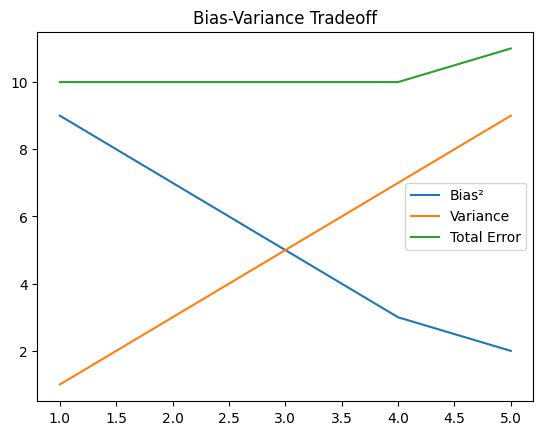

------------------------------------------------------------
Agent Used: Visualization Agent
Question: Plot bias-variance tradeoff
Answer: 📊 Plotted Bias-Variance Tradeoff.
------------------------------------------------------------



Ask a question (or type 'exit' to quit):  Explain regularization with L1 and L2.


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors


------------------------------------------------------------
Agent Used: Theory Agent
Question: Explain regularization with L1 and L2.
Answer: To create a regularized model, we modify the objective function by adding a penalizing term whose value is higher when the model is more complex.
------------------------------------------------------------



Ask a question (or type 'exit' to quit):  define Feed-Forward Neural Network Architecture


------------------------------------------------------------
Agent Used: Theory Agent
Question: define Feed-Forward Neural Network Architecture
Answer: If we want to solve a regression or a classification problem discussed in previous chapters, the last (the rightmost) layer of a neural network usually contains only one unit. If the activation function glast of the last unit is linear, then the neural network is a regression model. If the glast is a logistic function, the neural network is a binary classification model.
------------------------------------------------------------



Ask a question (or type 'exit' to quit):  Define Ensemble learning


------------------------------------------------------------
Agent Used: Theory Agent
Question: Define Ensemble learning
Answer: Bagging consists of creating many “copies” of the training data (each copy is slightly different from another) and then apply the weak learner to each copy to obtain multiple weak models and then combine them. The bagging paradigm is behind the random forest learning algorithm. The “vanilla” bagging algorithm works like follows. Given a training set, we create B random try to model. If we were unlucky with how our training set was sampled, then it could contain some undesirable (but unavoidable) artifacts: noise, outliers and over- or underrepresented examples. By creating multiple random samples with replacement of our training set, we reduce the effect of these arti
------------------------------------------------------------



Ask a question (or type 'exit' to quit):  exit


In [18]:
while True:
    query = input("\nAsk a question (or type 'exit' to quit): ")
    if query.lower() == "exit":
        break

    agent, answer = agent_router(query)
    print("------------------------------------------------------------")
    print("Agent Used:", agent)
    print("Question:", query)
    print("Answer:", answer)
    print("------------------------------------------------------------")